## Setup

### Imports

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

from src.ftm import constants as FTM_constants
from src.knn import Knn
from src.phi import JTFS_forward



### Create Parameters Dataset

In [2]:
# Create DataFrame and write it to a CSV file for later use

def create_DF(bounds, subdiv, path):
    
    #Linspace of every parameters of size k
    Dbase = np.zeros((subdiv,5))
    for i in range(5):
        Dbase[:,i] = np.linspace(bounds[1][i][0],bounds[1][i][1],subdiv)
    baseDF = pd.DataFrame(data=Dbase,columns=bounds[0])

    #Product of the linspaces to get all the possible combinations (size subdiv**5, will take time)
    D = list(product(baseDF['omega'],baseDF['tau'],baseDF['p'],baseDF['d'],baseDF['alpha']))
    DF = pd.DataFrame(data=D,columns=bounds[0])

    DF.to_csv(path)
    
    return DF

# Boundaries

bounds = [['omega', 'tau', 'p', 'd', 'alpha'],
 [(2.4, 3.8),
  (0.4, 3),
  (-5, -0.7),
  (-5, -0.5),
  (10e-05, 1)]]

## Main

In [25]:
# Only run this to recreate the parameters CSV, this can take some time to finish depending on the subdivisions
create_DF(bounds=bounds, subdiv=3, path='data/default_parameters.csv')

# Setting the parameters
DatasetPath = "data/default_parameters.csv"
DF = torch.from_numpy(pd.read_csv(DatasetPath, index_col=0).to_numpy()).to(device).to(torch.float)
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True
k = 10
i_r = 1

# Main job
print('computing the knn (P-loss)')
T_knn_ploss = Knn(DF,i_r,k,JTFS_forward,logscale,'P-loss')

print('computing the knn (Perceptual-KNN)')
T_knn_perceptualknn = Knn(DF,i_r,k,JTFS_forward,logscale,'Perceptual-KNN')

print('computing the knn (Bruteforce)')
T_knn_bruteforce = Knn(DF,i_r,k,JTFS_forward,logscale,'Bruteforce')

computing the knn (P-loss)
computing the knn (Perceptual-KNN)
computing the knn (Bruteforce)
S computation:  1 / 243
S computation:  2 / 243
S computation:  3 / 243
S computation:  4 / 243
S computation:  5 / 243
S computation:  6 / 243
S computation:  7 / 243
S computation:  8 / 243
S computation:  9 / 243
S computation:  10 / 243
S computation:  11 / 243
S computation:  12 / 243
S computation:  13 / 243
S computation:  14 / 243
S computation:  15 / 243
S computation:  16 / 243
S computation:  17 / 243
S computation:  18 / 243
S computation:  19 / 243
S computation:  20 / 243
S computation:  21 / 243
S computation:  22 / 243
S computation:  23 / 243
S computation:  24 / 243
S computation:  25 / 243
S computation:  26 / 243
S computation:  27 / 243
S computation:  28 / 243
S computation:  29 / 243
S computation:  30 / 243
S computation:  31 / 243
S computation:  32 / 243
S computation:  33 / 243
S computation:  34 / 243
S computation:  35 / 243
S computation:  36 / 243
S computation:  

In [ ]:
#TEST THE DERIVATION PIPELINE

from src.distances import distance_factory
from src.jacobian import M_factory
from src.phi import JTFS_forward
from src.ftm import rectangular_drum
from src.ftm import constants as FTM_constants
DatasetPath = "data/default_parameters.csv"
DF = torch.from_numpy(pd.read_csv(DatasetPath, index_col=0).to_numpy()).to(device).to(torch.float)
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True

theta_r = DF[0,:]
theta_c = DF[2,:]

x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
phi = JTFS_forward

s = phi(x_r)

print(x_r.type())
print(s.size())

M = M_factory(logscale,phi)

M_r = M(theta_r)

M_r

torch.cuda.FloatTensor
torch.Size([101008])


tensor([[ 3.2407e+07, -2.7094e+05, -3.3474e+04,  8.8867e+05, -3.7140e+09],
        [-2.7094e+05,  1.3639e+05, -1.2047e+04, -3.9631e+03,  6.9529e+07],
        [-3.3474e+04, -1.2047e+04,  9.8887e+03, -7.0244e+03, -1.2440e+07],
        [ 8.8867e+05, -3.9631e+03, -7.0244e+03,  1.8342e+05, -7.6606e+08],
        [-3.7140e+09,  6.9529e+07, -1.2440e+07, -7.6606e+08,  3.3810e+12]],
       device='cuda:0')

# Method characterization

In [27]:
from src.distances import distance_factory
from src.phi import JTFS_forward
from src.ftm import rectangular_drum

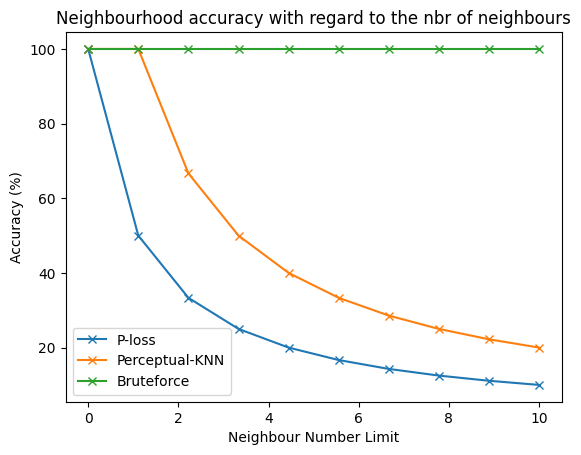

In [29]:
LMBAcc = []
LMPKNNAcc = []
LMPAcc = []

for klim in range(1,k+1):

    BruteforceAcc = 0.
    PerceptualKNNAcc = 0.
    PlossAcc = 0.

    for i_knn in range(klim):
        BruteforceAcc += (T_knn_bruteforce[i_knn,:] == T_knn_bruteforce[i_knn,:]).all()
        PerceptualKNNAcc += (T_knn_perceptualknn[i_knn,:] == T_knn_bruteforce[i_knn,:]).all()
        PlossAcc += (T_knn_ploss[i_knn,:] == T_knn_bruteforce[i_knn,:]).all()

    MeanBruteforceAcc = 100.0*BruteforceAcc/klim
    MeanPerceptualKNNAcc = 100.0*PerceptualKNNAcc/klim
    MeanPlossAcc = 100.0*PlossAcc/klim

    LMBAcc.append(MeanBruteforceAcc.cpu())
    LMPKNNAcc.append(MeanPerceptualKNNAcc.cpu())
    LMPAcc.append(MeanPlossAcc.cpu())

plt.figure(0)
x = np.linspace(0,k,k)
plt.plot(x,LMPAcc,'-x',x,LMPKNNAcc,'-x',x,LMBAcc,'-x')
plt.xlabel("Neighbour Number Limit")
plt.ylabel("Accuracy (%)")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("Neighbourhood accuracy with regard to the nbr of neighbours")
plt.show()

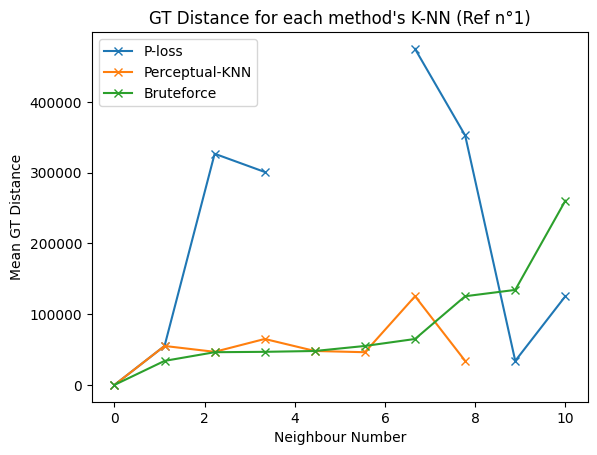

In [23]:
theta_r = T_knn_bruteforce[0,:]
x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
phi = JTFS_forward
S_r = phi(x_r)

dist = distance_factory("Bruteforce")

Dploss = []
Dperceptualknn = []
Dbruteforce = []

for i in range(k):
    S_c_ploss = phi(rectangular_drum(T_knn_ploss[i,:], logscale, **FTM_constants))
    S_c_perceptual = phi(rectangular_drum(T_knn_perceptualknn[i,:], logscale, **FTM_constants))
    S_c_bruteforce = phi(rectangular_drum(T_knn_bruteforce[i,:], logscale, **FTM_constants))

    Dploss.append(dist(S_c_ploss,S_r).item())
    Dperceptualknn.append(dist(S_c_perceptual,S_r).item())
    Dbruteforce.append(dist(S_c_bruteforce,S_r).item())

plt.figure(1)
x = np.linspace(0,len(Dploss),len(Dploss))
plt.plot(x,Dploss,'-x',x,Dperceptualknn,'-x',x,Dbruteforce,'-x')
plt.xlabel("Neighbour Number")
plt.ylabel("Mean GT Distance")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("GT Distance for each method's K-NN (Ref n°"+str(i_r)+")")
plt.show()